In [1]:
from Autoencoder import *
from make_video import *

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer,Conv2D,MaxPool2D,\
UpSampling2D,Conv2DTranspose,Cropping2D,Add,add
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs


## Parameters

In [2]:
## For Current PC
# DATASET = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
# DATASET_NAME = r'bunny_video.mp4' ## Name of the video
# FRAMES = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
# RECONSTRUCTED = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved

## For NAON PC
DATASET = r'C:\Users\saad\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
DATASET_NAME = r'bunny_video.mp4' ## Name of the video
FRAMES = r'C:\Users\saad\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
RECONSTRUCTED = r'C:\Users\saad\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved

## initial w,h are 640,480
WIDTH = 640 ## width of the reconstrcted image
HEIGHT = 480 ## height of the reconstrcted image
FPS = 25 ## fps of the reconstrcted image
SLICES = 2 ## Number of slices to be made on the image

EMBEDDING_SIZE = 512 ## bottleneck layer nodes

Loading Video...
Completed
The fps is 25.0, The width of the frame is 1280 and the height of the frame is 720
(1478, 480, 320, 3)


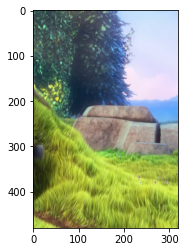

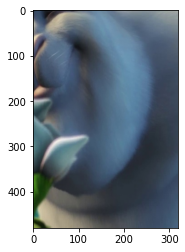

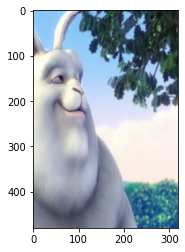

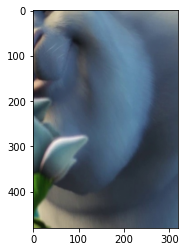

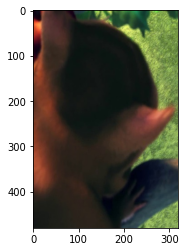

In [3]:
names,fps,width,height = read_video(FRAMES,os.path.join(DATASET,DATASET_NAME))

print(f'The fps is {fps}, The width of the frame is {width} and the height of the frame is {height}')

images1 = np.array(read_imgs(FRAMES,names,SLICES,WIDTH,HEIGHT))
print(images1.shape)
images = images1.astype('float32')/255.

## Sanity check on the images
ran = random.sample(range(0,len(images)),5)
for r in ran:
    plt.imshow(images[r])
    plt.show()

In [4]:
images.shape

(1478, 480, 320, 3)

In [5]:
train,test = splitter(images,0.1)
print(f'The shape of train is {train.shape}')
print(f'The shape of test is {test.shape}')

The shape of train is (1330, 480, 320, 3)
The shape of test is (148, 480, 320, 3)


In [ ]:
## SSIM = 0.94
# The encoder
encoder = Sequential()
encoder.add(InputLayer((480,320,3)))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))

# The decoder
decoder = Sequential()
decoder.add(InputLayer((30,20,32)))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))

In [ ]:
## Residual Autoencoder - Take 1
# SSIM = 0.99

# The encoder
encoder_1 = Input((480,320,3),name='encoder_input')
encoder_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer1')(encoder_1)
encoder_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer2')(encoder_2)
encoder_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer3')(encoder_3)
encoder_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer4')(encoder_4)

# encoder = Model(encoder_1,encoder_5)

# The decoder
# decoder_1 = Input((30,20,32),name='decoder_input')
decoder_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer1')(encoder_5)
add_1 = add([decoder_2,encoder_4]) # Residual Network
decoder_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer2')(add_1)
decoder_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer3')(decoder_3)
add_2 = add([decoder_4,encoder_2]) # Residual Network
decoder_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='DLayer4')(add_2)

autoencoder = Model(encoder_1,decoder_5)

autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
autoencoder.summary()

In [ ]:
## Hi-res Autoencoders - Take 1

##################################
####### First Autoencoder ########
##################################

# The encoder 1
encoder1_1 = Input((480,320,3),name='encoder1_input')
encoder1_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer1')(encoder1_1)
encoder1_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer2')(encoder1_2)
encoder1_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer3')(encoder1_3)
encoder1_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer4')(encoder1_4)

encoder1 = Model(encoder1_1,encoder1_5)

# The decoder 1
decoder1_1 = Input((30,20,32),name='decoder1_input')
decoder1_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer1')(decoder1_1)
decoder1_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer2')(decoder1_2)
decoder1_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer3')(decoder1_3)
decoder1_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D1Layer4')(decoder1_4)

decoder1 = Model(decoder1_1,decoder1_5)

inp = Input((480,320,3))
code = encoder1(inp)
reconstruction = decoder1(code)
autoencoder1 = Model(inp,reconstruction)

##################################
####### Second Autoencoder #######
##################################

# The encoder 2
encoder2_1 = autoencoder1.output #Input((480,320,3),name='encoder2_input')
encoder2_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer1')(encoder2_1)
encoder2_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer2')(encoder2_2)
encoder2_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer3')(encoder2_3)
encoder2_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer4')(encoder2_4)

# The decoder 2
decoder2_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer1')(encoder2_5)
add2_1 = add([decoder2_2,encoder2_4]) # Residual Connection 
decoder2_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer2')(add2_1)
decoder2_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer3')(decoder2_3)
add2_2 = add([decoder2_4,encoder2_2]) # Residual Connection 
decoder2_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D2Layer4')(add2_2)

# autoencoder2 = Model(encoder2_1,decoder2_5)

autoencoder = Model(autoencoder1.input,decoder2_5)

# autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
# autoencoder.summary()

In [10]:
## Hi-res Autoencoders - Take 2

##################################
####### First Autoencoder ########
##################################

# The encoder 1
encoder1_1 = Input((480,320,3),name='encoder1_input')
encoder1_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer1')(encoder1_1)
encoder1_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer2')(encoder1_2)
encoder1_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer3')(encoder1_3)
encoder1_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer4')(encoder1_4)

encoder1 = Model(encoder1_1,encoder1_5)

# The decoder 1
decoder1_1 = Input((30,20,32),name='decoder1_input')
decoder1_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer1')(decoder1_1)
decoder1_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer2')(decoder1_2)
decoder1_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer3')(decoder1_3)
decoder1_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D1Layer4')(decoder1_4)

decoder1 = Model(decoder1_1,decoder1_5)

inp = Input((480,320,3))
code = encoder1(inp)
reconstruction = decoder1(code)
autoencoder1 = Model(inp,reconstruction)

##################################
####### Second Autoencoder #######
##################################

# The encoder 2
encoder2_1 = Input((480,320,3),name='encoder2_input')
encoder2_2 = Conv2D(filters=256,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer1')(encoder2_1)
encoder2_3 = Conv2D(filters=128,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer2')(encoder2_2)
encoder2_4 = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer3')(encoder2_3)
encoder2_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='E2Layer4')(encoder2_4)

# The decoder 2
decoder2_2 = Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer1')(encoder2_5)
add2_1 = add([decoder2_2,encoder2_4]) # Residual Connection 
decoder2_3 = Conv2DTranspose(filters=128,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer2')(add2_1)
decoder2_4 = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer3')(decoder2_3)
add2_2 = add([decoder2_4,encoder2_2]) # Residual Connection 
decoder2_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',activation='relu',activity_regularizer=l1(10e-10),name='D2Layer4')(add2_2)

autoencoder2 = Model(encoder2_1,decoder2_5)

# autoencoder = Model(autoencoder1.input,decoder2_5)

# autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
# autoencoder.summary()

In [11]:
encoder1.summary(), decoder1.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder1_input (InputLayer)  [(None, 480, 320, 3)]     0         
_________________________________________________________________
E1Layer1 (Conv2D)            (None, 240, 160, 32)      896       
_________________________________________________________________
E1Layer2 (Conv2D)            (None, 120, 80, 32)       9248      
_________________________________________________________________
E1Layer3 (Conv2D)            (None, 60, 40, 32)        9248      
_________________________________________________________________
E1Layer4 (Conv2D)            (None, 30, 20, 32)        9248      
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
_________________________________________________________________
Model: "functional_15"
_________________________________________________________________
Layer (type)              

(None, None)

In [12]:
autoencoder2.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder2_input (InputLayer)     [(None, 480, 320, 3) 0                                            
__________________________________________________________________________________________________
E2Layer1 (Conv2D)               (None, 240, 160, 256 7168        encoder2_input[0][0]             
__________________________________________________________________________________________________
E2Layer2 (Conv2D)               (None, 120, 80, 128) 295040      E2Layer1[0][0]                   
__________________________________________________________________________________________________
E2Layer3 (Conv2D)               (None, 60, 40, 64)   73792       E2Layer2[0][0]                   
______________________________________________________________________________________

In [13]:
autoencoder2.compile(loss='mse',optimizer='adam',metrics=['mae'])
filepath2 = 'weights_combo2.hdf5'
checkpoint2 = ModelCheckpoint(filepath2,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

Epoch 1/200
240/240 [==============================] - 4s 17ms/step - loss: 0.0272 - mae: 0.1071 - val_loss: 0.0060 - val_mae: 0.0534
Epoch 2/200
240/240 [==============================] - 4s 15ms/step - loss: 0.0045 - mae: 0.0456 - val_loss: 0.0039 - val_mae: 0.0423
Epoch 3/200
240/240 [==============================] - 4s 15ms/step - loss: 0.0036 - mae: 0.0408 - val_loss: 0.0037 - val_mae: 0.0445
Epoch 4/200
240/240 [==============================] - 4s 15ms/step - loss: 0.0034 - mae: 0.0406 - val_loss: 0.0030 - val_mae: 0.0380
Epoch 5/200
240/240 [==============================] - 4s 15ms/step - loss: 0.0029 - mae: 0.0370 - val_loss: 0.0025 - val_mae: 0.0353
Epoch 6/200
240/240 [==============================] - 4s 15ms/step - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0018 - val_mae: 0.0258
Epoch 7/200
240/240 [==============================] - 4s 15ms/step - loss: 0.0022 - mae: 0.0293 - val_loss: 0.0050 - val_mae: 0.0546
Epoch 8/200
240/240 [==============================] - 4s 15ms

240/240 [==============================] - 4s 15ms/step - loss: 6.9149e-04 - mae: 0.0165 - val_loss: 6.4080e-04 - val_mae: 0.0153
Epoch 59/200
240/240 [==============================] - 4s 15ms/step - loss: 6.2532e-04 - mae: 0.0144 - val_loss: 6.1997e-04 - val_mae: 0.0142
Epoch 60/200
240/240 [==============================] - 4s 15ms/step - loss: 7.4741e-04 - mae: 0.0170 - val_loss: 6.3775e-04 - val_mae: 0.0151
Epoch 61/200
240/240 [==============================] - 4s 15ms/step - loss: 6.2469e-04 - mae: 0.0143 - val_loss: 6.1736e-04 - val_mae: 0.0141
Epoch 62/200
240/240 [==============================] - 4s 15ms/step - loss: 6.3629e-04 - mae: 0.0148 - val_loss: 6.2890e-04 - val_mae: 0.0148
Epoch 63/200
240/240 [==============================] - 4s 15ms/step - loss: 0.0012 - mae: 0.0217 - val_loss: 6.3330e-04 - val_mae: 0.0144
Epoch 64/200
240/240 [==============================] - 4s 15ms/step - loss: 6.2041e-04 - mae: 0.0140 - val_loss: 6.1599e-04 - val_mae: 0.0140
Epoch 65/200
240

240/240 [==============================] - 4s 15ms/step - loss: 5.7841e-04 - mae: 0.0135 - val_loss: 5.8138e-04 - val_mae: 0.0138
Epoch 116/200
240/240 [==============================] - 4s 15ms/step - loss: 6.3507e-04 - mae: 0.0153 - val_loss: 5.8615e-04 - val_mae: 0.0139
Epoch 117/200
240/240 [==============================] - 4s 15ms/step - loss: 6.6733e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 118/200
240/240 [==============================] - 4s 15ms/step - loss: 6.0410e-04 - mae: 0.0144 - val_loss: 5.7898e-04 - val_mae: 0.0136
Epoch 119/200
240/240 [==============================] - 4s 15ms/step - loss: 5.7792e-04 - mae: 0.0135 - val_loss: 5.7973e-04 - val_mae: 0.0137
Epoch 120/200
240/240 [==============================] - 4s 15ms/step - loss: 5.8284e-04 - mae: 0.0138 - val_loss: 5.7801e-04 - val_mae: 0.0136
Epoch 121/200
240/240 [==============================] - 4s 15ms/step - loss: 5.7942e-04 - mae: 0.0137 - val_loss: 5.8203e-04 - val_mae: 0.0138
Epoch 122/

240/240 [==============================] - 4s 15ms/step - loss: 6.5537e-04 - mae: 0.0157 - val_loss: 5.7926e-04 - val_mae: 0.0137
Epoch 173/200
240/240 [==============================] - 4s 15ms/step - loss: 5.7510e-04 - mae: 0.0136 - val_loss: 5.7662e-04 - val_mae: 0.0137
Epoch 174/200
240/240 [==============================] - 4s 15ms/step - loss: 5.7374e-04 - mae: 0.0135 - val_loss: 5.7528e-04 - val_mae: 0.0136
Epoch 175/200
240/240 [==============================] - 4s 15ms/step - loss: 5.7307e-04 - mae: 0.0135 - val_loss: 5.7461e-04 - val_mae: 0.0136
Epoch 176/200
240/240 [==============================] - 4s 15ms/step - loss: 6.2189e-04 - mae: 0.0152 - val_loss: 7.5122e-04 - val_mae: 0.0197
Epoch 177/200
240/240 [==============================] - 4s 15ms/step - loss: 6.2067e-04 - mae: 0.0150 - val_loss: 5.7479e-04 - val_mae: 0.0136
Epoch 178/200
240/240 [==============================] - 4s 15ms/step - loss: 5.7281e-04 - mae: 0.0135 - val_loss: 5.7427e-04 - val_mae: 0.0136
Epoch 

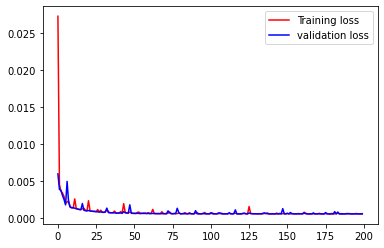

In [14]:
autoencoder1.compile(loss='mse',optimizer='adam',metrics=['mae'])
# autoencoder2.compile(loss='mse',optimizer='adam',metrics=['mae'])

filepath1 = 'weights_combo1.hdf5'
checkpoint1 = ModelCheckpoint(filepath1,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

filepath2 = 'weights_combo2.hdf5'
checkpoint2 = ModelCheckpoint(filepath2,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

history1 = autoencoder1.fit(train,train,epochs=200,batch_size=5,validation_split=0.1,callbacks=[checkpoint1])

plt.plot(history1.history['loss'],'r',label='Training loss')
plt.plot(history1.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


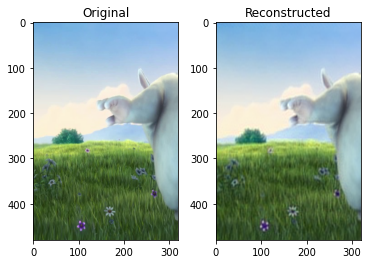

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9428093255458021


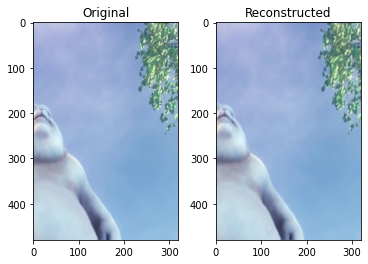

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9739169917029624


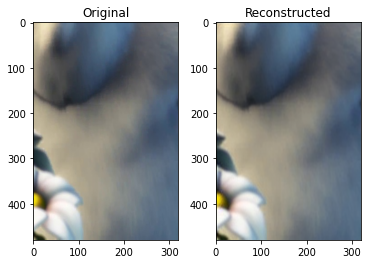

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9953543400567659


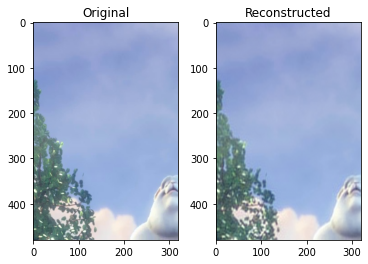

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------ 0.9734564420696292


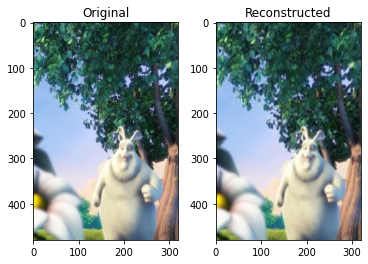

------------------------------ 0.902358894124626


In [15]:
autoencoder1.load_weights(filepath1)

num = random.sample(range(0,len(train)),5)

for i in num:
    im = train[i]
    pred=autoencoder1.predict(np.expand_dims(im,axis=0))
    plt.subplot(121)
    plt.imshow(im)
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(pred[0,:,:,:])
    plt.title('Reconstructed')
    
    plt.show()
    
    print('-'*30,overall_ssim(train[i],pred[0,:,:,:]))

In [16]:
import gc
train_intermediate = []
for i in range(len(train)):
    if i%5 == 0:
        print(i)
    imgs_new = np.expand_dims(train[i],axis=0)
    t=autoencoder1.predict(imgs_new)
    train_intermediate.append(t)
    del(t)
    del(imgs_new)
    gc.collect()
    
train_intermediate=np.array(train_intermediate)
train_intermediate=train_intermediate.reshape(train_intermediate.shape[0],train_intermediate.shape[2],
                                              train_intermediate.shape[3],train_intermediate.shape[4])

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

In [17]:
train_intermediate.shape

(1330, 480, 320, 3)

In [18]:
train.shape

(1330, 480, 320, 3)

In [19]:
overall_ssim(train,train_intermediate)

0.9491224562010109

In [ ]:
del(pred)
gc.collect()

Epoch 1/200
240/240 [==============================] - 17s 69ms/step - loss: 0.0115 - mae: 0.0448 - val_loss: 0.0017 - val_mae: 0.0156
Epoch 2/200
240/240 [==============================] - 16s 67ms/step - loss: 0.0015 - mae: 0.0149 - val_loss: 0.0014 - val_mae: 0.0145
Epoch 3/200
240/240 [==============================] - 16s 67ms/step - loss: 0.0013 - mae: 0.0143 - val_loss: 0.0012 - val_mae: 0.0142
Epoch 4/200
240/240 [==============================] - 16s 67ms/step - loss: 0.0011 - mae: 0.0142 - val_loss: 0.0011 - val_mae: 0.0140
Epoch 5/200
240/240 [==============================] - 16s 67ms/step - loss: 0.0010 - mae: 0.0140 - val_loss: 9.8553e-04 - val_mae: 0.0139
Epoch 6/200
240/240 [==============================] - 16s 67ms/step - loss: 9.5837e-04 - mae: 0.0138 - val_loss: 9.4190e-04 - val_mae: 0.0141
Epoch 7/200
240/240 [==============================] - 16s 68ms/step - loss: 9.3026e-04 - mae: 0.0139 - val_loss: 9.1787e-04 - val_mae: 0.0137
Epoch 8/200
240/240 [==============

240/240 [==============================] - 16s 67ms/step - loss: 6.3513e-04 - mae: 0.0118 - val_loss: 6.1332e-04 - val_mae: 0.0110
Epoch 59/200
240/240 [==============================] - 16s 67ms/step - loss: 6.0435e-04 - mae: 0.0108 - val_loss: 6.0795e-04 - val_mae: 0.0109
Epoch 60/200
240/240 [==============================] - 16s 67ms/step - loss: 6.0771e-04 - mae: 0.0110 - val_loss: 6.0743e-04 - val_mae: 0.0109
Epoch 61/200
240/240 [==============================] - 16s 67ms/step - loss: 6.0103e-04 - mae: 0.0108 - val_loss: 6.2347e-04 - val_mae: 0.0117
Epoch 62/200
240/240 [==============================] - 16s 66ms/step - loss: 6.1620e-04 - mae: 0.0115 - val_loss: 6.2490e-04 - val_mae: 0.0116
Epoch 63/200
240/240 [==============================] - 16s 67ms/step - loss: 5.9869e-04 - mae: 0.0108 - val_loss: 6.0360e-04 - val_mae: 0.0108
Epoch 64/200
240/240 [==============================] - 16s 67ms/step - loss: 5.9974e-04 - mae: 0.0108 - val_loss: 6.0346e-04 - val_mae: 0.0111
Epoch

Epoch 115/200
240/240 [==============================] - 16s 67ms/step - loss: 5.6399e-04 - mae: 0.0108 - val_loss: 5.8264e-04 - val_mae: 0.0113
Epoch 116/200
240/240 [==============================] - 16s 67ms/step - loss: 5.4534e-04 - mae: 0.0102 - val_loss: 5.4573e-04 - val_mae: 0.0100
Epoch 117/200
240/240 [==============================] - 16s 67ms/step - loss: 5.4144e-04 - mae: 0.0100 - val_loss: 5.4456e-04 - val_mae: 0.0100
Epoch 118/200
240/240 [==============================] - 16s 67ms/step - loss: 5.4236e-04 - mae: 0.0101 - val_loss: 5.5384e-04 - val_mae: 0.0104
Epoch 119/200
240/240 [==============================] - 16s 67ms/step - loss: 5.4389e-04 - mae: 0.0102 - val_loss: 5.4784e-04 - val_mae: 0.0101
Epoch 120/200
240/240 [==============================] - 16s 67ms/step - loss: 5.5052e-04 - mae: 0.0104 - val_loss: 5.4923e-04 - val_mae: 0.0102
Epoch 121/200
240/240 [==============================] - 16s 67ms/step - loss: 5.4211e-04 - mae: 0.0101 - val_loss: 5.5644e-04 - v

240/240 [==============================] - 16s 66ms/step - loss: 5.2592e-04 - mae: 0.0100 - val_loss: 5.4164e-04 - val_mae: 0.0107
Epoch 172/200
240/240 [==============================] - 16s 66ms/step - loss: 5.2839e-04 - mae: 0.0101 - val_loss: 5.3199e-04 - val_mae: 0.0100
Epoch 173/200
240/240 [==============================] - 16s 66ms/step - loss: 5.3017e-04 - mae: 0.0102 - val_loss: 5.2572e-04 - val_mae: 0.0098
Epoch 174/200
240/240 [==============================] - 16s 66ms/step - loss: 5.1964e-04 - mae: 0.0097 - val_loss: 5.2852e-04 - val_mae: 0.0099
Epoch 175/200
240/240 [==============================] - 16s 66ms/step - loss: 5.2696e-04 - mae: 0.0100 - val_loss: 5.3075e-04 - val_mae: 0.0101
Epoch 176/200
240/240 [==============================] - 16s 66ms/step - loss: 5.2224e-04 - mae: 0.0098 - val_loss: 5.2355e-04 - val_mae: 0.0097
Epoch 177/200
240/240 [==============================] - 16s 66ms/step - loss: 5.2306e-04 - mae: 0.0099 - val_loss: 5.2656e-04 - val_mae: 0.0098

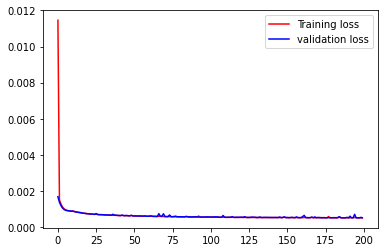

In [20]:
history2=autoencoder2.fit(train_intermediate,train,epochs=200,batch_size=5,validation_split=0.1,callbacks=[checkpoint2])

plt.plot(history2.history['loss'],'r',label='Training loss')
plt.plot(history2.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

In [ ]:
# autoencoder2.load_weights(filepath2)

num = random.sample(range(0,len(train_intermediate)),5)

for i in num:
    im = train_intermediate[i]
    pred=autoencoder2.predict(np.expand_dims(im,axis=0))
    plt.subplot(121)
    plt.imshow(im)
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(pred[0,:,:,:])
    plt.title('Reconstructed')
    
    plt.show()
    
    print('-'*30,overall_ssim(train_intermediate[i],pred[0,:,:,:]))

In [ ]:
autoencoder1.load_weights(filepath1)
test_intermediate = autoencoder1.predict(test)
test_preds = autoencoder2.predict(test_intermediate)

overall_ssim(test,test_preds)

In [ ]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    preds=autoencoder2.predict(autoencoder1.predict(imgs_new))
    pred.append(preds)
    del(preds)
#     del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

In [ ]:
overall_ssim(images,pred1)

In [ ]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [ ]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [ ]:
video = cv2.VideoWriter('recon3.avi', 0 , 25.0, (320,240))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
inp = Input((480,320,3))
code = encoder(inp)
reconstruction = decoder(code)
model = Model(inp,reconstruction)
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
model.summary()

In [ ]:
filepath = 'weights_32_res.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

history=autoencoder.fit(train,train,epochs=50,batch_size=5,validation_split=0.1,callbacks=[checkpoint])

plt.plot(history.history['loss'],'r',label='Training loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.load_weights(filepath)

num = random.sample(range(0,len(test)),5)

for i in num:
    im = test[i]
    pred=autoencoder.predict(np.expand_dims(im,axis=0))
    plt.subplot(121)
    plt.imshow(im)
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(pred[0,:,:,:])
    plt.title('Reconstructed')
    
    plt.show()

In [ ]:
predicted=autoencoder.predict(test)
overall_ssim(test,predicted)

In [ ]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    preds=autoencoder.predict(imgs_new)
    pred.append(preds)
    del(preds)
#     del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

In [ ]:
overall_ssim(images,pred1)

In [ ]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [ ]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [ ]:
video = cv2.VideoWriter('recon1.avi', 0 , 25.0, (640,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
model.load_weights(filepath)

num_test = random.sample(range(0,len(test)),5)
for i in num_test:
    img = test[i]
    visualize(img,encoder,decoder)

In [ ]:
bottle = encoder.predict(test)
predicted = decoder.predict(bottle)
overall_ssim(test,predicted)

In [ ]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    code = encoder.predict(imgs_new)
    preds = decoder.predict(code)
    pred.append(preds)
    del(preds)
    del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

In [ ]:
pred1.shape

In [ ]:
overall_ssim(images,pred1)

In [ ]:
p = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames'
p = p.replace('\\','/')

In [ ]:
p1=os.getcwd()
os.chdir(p)
os.getcwd()

In [ ]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [ ]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (320,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
x1 = cv2.imread(names1[0])
x2 = cv2.imread(names1[1])
x3 = cv2.imread(names1[2])
x4 = cv2.imread(names1[3])

plt.subplot(141)
plt.imshow(x1)

plt.subplot(142)
plt.imshow(x2)

plt.subplot(143)
plt.imshow(x3)

plt.subplot(144)
plt.imshow(x4)

In [ ]:
x_1 = cv2.hconcat([x1,x2])
plt.imshow(x_1)

In [ ]:
os.getcwd()

In [ ]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [ ]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (640,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
os.chdir('C:/Users/Saad.LAKES/Desktop/Autoencoders/Videos/Results/Video_Frames')

In [ ]:
video1 = cv2.VideoWriter('original.avi', 0 , 25.0, (640,480))
for image in names:
    video1.write(cv2.imread(image))
cv2.destroyAllWindows()
video1.release()

In [ ]:
plt.imshow(images1[0])

In [ ]:
plt.subplot(141)
plt.imshow(imCrop(images[1],2)[0])
plt.subplot(142)
plt.imshow(imCrop(images[1],2)[1])
# plt.subplot(143)
# plt.imshow(imCrop(images[1],4)[2])
# plt.subplot(144)
# plt.imshow(imCrop(images[1],4)[3])

In [ ]:
images[1].shape

In [ ]:
images[1][540,480]

In [ ]:
x=image_slicer.slice('frame_1.jpg',16,save=False)

In [ ]:
from PIL import ImageDraw, ImageFont

In [ ]:
for tile in x:
    overlay = ImageDraw.Draw(tile.image)

In [ ]:
overlay

In [ ]:
np.asarray(x[1].image)

In [ ]:
# filterss = 16
# SSIM =0.90
# # The encoder
# encoder = Sequential()
# encoder.add(InputLayer((480,320,3)))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))


# # The decoder
# decoder = Sequential()
# decoder.add(InputLayer((30,20,filterss)))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))